In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from my_xgboost import XGBoost

# 加载数据集
data = load_diabetes()
X, y = data.data, data.target
feature_names = data.feature_names

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 结果收集字典
results = {}

def evaluate_model(y_true, y_pred):
    return {
        'MSE': mean_squared_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

# =====================
# 1. XGBoost
# =====================
start_time = time.time()
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
xgb_model.fit(X_train, y_train)
train_time = time.time() - start_time

results['XGBoost'] = evaluate_model(y_test, xgb_model.predict(X_test))
results['XGBoost']['Time'] = train_time

# =====================
# 2. Scikit-learn
# =====================
start_time = time.time()
sk_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
sk_model.fit(X_train, y_train)
train_time = time.time() - start_time

results['Sklearn'] = evaluate_model(y_test, sk_model.predict(X_test))
results['Sklearn']['Time'] = train_time

# # =====================
# # 3. H2O
# # =====================
# h2o.init()
# train_h2o = h2o.H2OFrame(np.column_stack((X_train, y_train)), 
#                        column_names=list(feature_names)+['target'])
# test_h2o = h2o.H2OFrame(np.column_stack((X_test, y_test)), 
#                       column_names=list(feature_names)+['target'])

# start_time = time.time()
# h2o_model = H2OGradientBoostingEstimator(
#     ntrees=100,
#     learn_rate=0.1,
#     max_depth=3,
#     seed=42,
#     distribution="gaussian"
# )
# h2o_model.train(x=feature_names, y="target", training_frame=train_h2o)
# train_time = time.time() - start_time

# results['H2O'] = evaluate_model(y_test, h2o_model.predict(test_h2o).as_data_frame()['predict'].values)
# results['H2O']['Time'] = train_time
# h2o.cluster().shutdown()

# =====================
# 4. My XGBoost
# =====================
start_time = time.time()
my_model = XGBoost(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    eps=1e-2
)
my_model.fit(X_train, y_train)
train_time = time.time() - start_time

results['My XGBoost'] = evaluate_model(y_test, my_model.predict(X_test))
results['My XGBoost']['Time'] = train_time

Training XGBoost: 100%|██████████████| 100/100 [elapsed: 00:02 remaining: 00:00]


<Figure size 1800x1200 with 0 Axes>

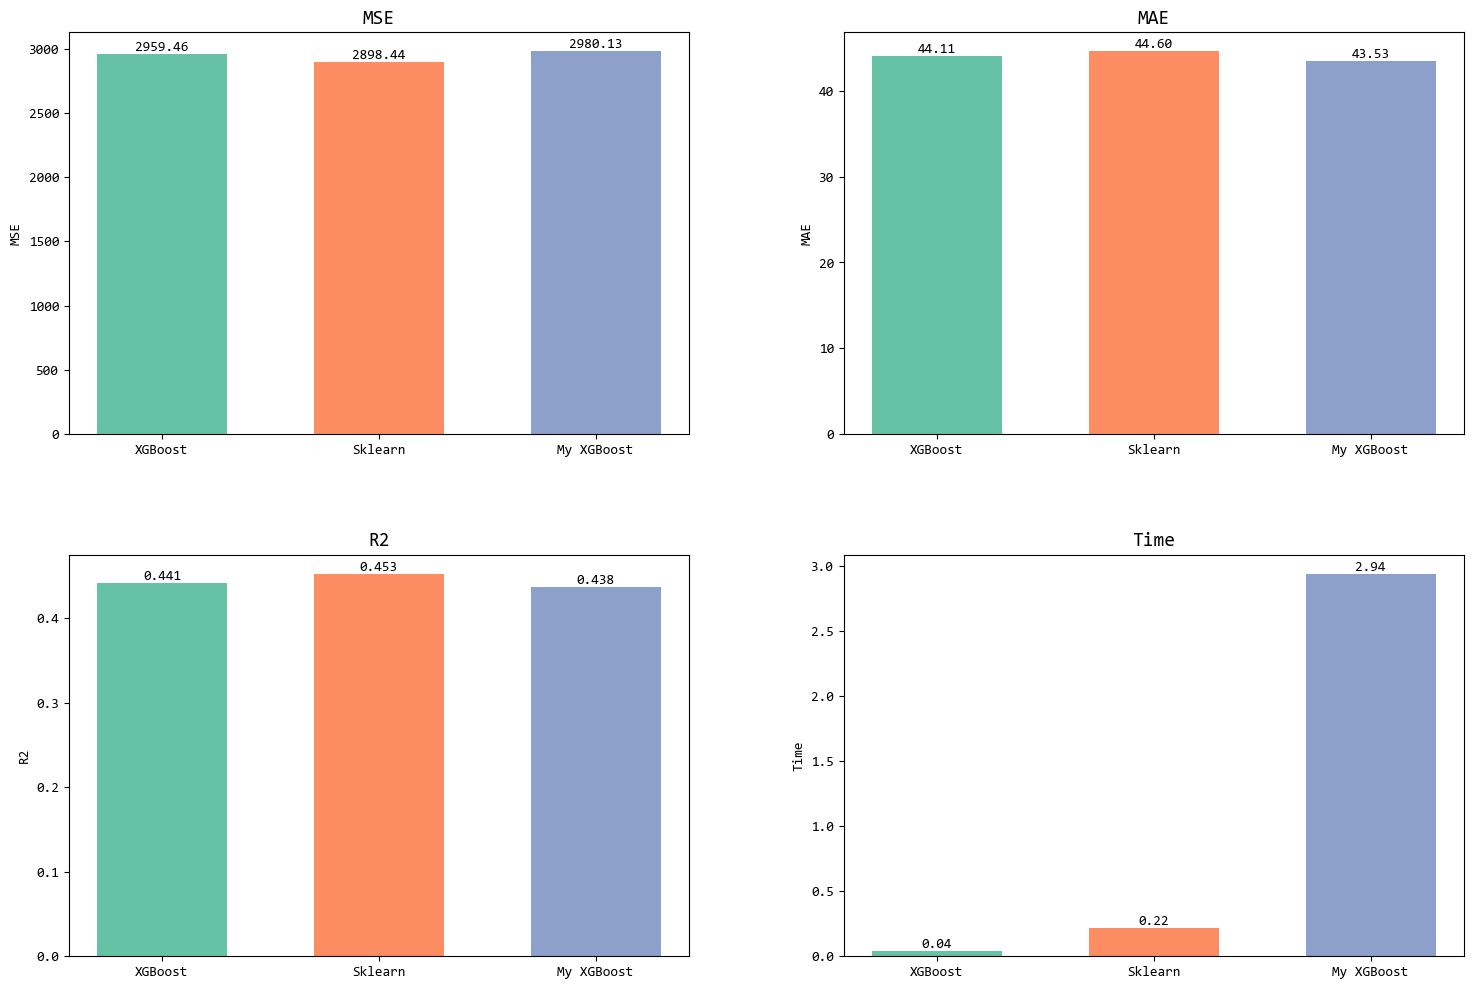

: 

In [ ]:
# =====================
# 可视化
# =====================
plt.rcParams['font.sans-serif'] = ['Consolas']
plt.figure(figsize=(18, 12))
models = list(results.keys())
metrics = ['MSE', 'MAE', 'R2', 'Time']
titles = ['MSE', 'MAE', 'R2', 'Time']
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

fig, axs = plt.subplots(2, 2, figsize=(18, 12))

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axs[idx//2, idx%2]
    x = range(len(models))
    values = [results[model][metric] for model in models]
    
    bars = ax.bar(x, values, color=colors, width=0.6)
    
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(metric)
    
    for bar in bars:
        height = bar.get_height()
        va = 'bottom' if height > 0 else 'top'
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}' if metric != 'R2' else f'{height:.3f}',
                ha='center', va=va, fontsize=10)

plt.subplots_adjust(hspace=0.3, wspace=0.25)
plt.show()